## Functionality: visualization of functional connectivity

<ul>
    <li>142 channels = 1-96 channels (M1) + 97-100(not used) + 101-132(ThaSMA) + 133-146 (GP/STN)</li>
    <li>load animetafolder/pinky_locThaSMA.csv for the details of ThaSMA </li>
</ul>

## Import Packages 

In [1]:
import os, sys
import numpy as np

import pickle

# import_nbmodule used for import package in .ipynb
import import_nbmodule

# add path '../'
sys.path.append(os.path.abspath(os.path.join('..')))

# import animal_folder in ../util/folder_extract.pynb 
from util.folder_extract import animal_folder


# import graphVisual in ../connAnalyTool/graphVisual.pynb 
from connAnalyTool import graphVisual


from igraph.drawing.text import TextDrawer
import cairo

importing Jupyter notebook from /home/lingling/yang7003@umn.edu/NMRC_umn/Codes/FCAnalysis/util/folder_extract.ipynb
importing Jupyter notebook from /home/lingling/yang7003@umn.edu/NMRC_umn/Codes/FCAnalysis/connAnalyTool/graphVisual.ipynb


## load the ciCOH matrix

### Load Beta band ciCOH
1. dic_ciCOH.keys() = ['ciCOH_beta1_normal', 'ciCOH_beta1_mild', 'ciCOH_beta2_normal', 'ciCOH_beta2_mild']

In [2]:
def ciCOHBetabandLoad(aniresfolder):
    """
        load beta band ciCOH
        
        
        @return ciCOH_beta1_normal, ciCOH_beta1_mild: bata1 band ciCOH values in normal and mild conditions
                                                      (ndarray: nchns * nchns * ntrials)
        
        @return ciCOH_beta2_normal, ciCOH_beta2_mild: bata2 band ciCOH values in normal and mild conditions 
                                                      (ndarray: nchns * nchns * ntrials)
        
    """

    # file storing the ciCOH results
    ciCOHfile = os.path.join(aniresfolder, 'res_ciCOH_beta.pickle')

    # load res_ciCOH
    res_ciCOH_beta = pickle.load(open(ciCOHfile, "rb" ))

    # ciCOH_beta1_normal, ciCOH_beta1_mild
    ciCOH_beta1_normal, ciCOH_beta1_mild = res_ciCOH_beta['ciCOH_beta1_normal'], res_ciCOH_beta['ciCOH_beta1_mild']

    # ciCOH_beta2_normal, ciCOH_beta2_mild
    ciCOH_beta2_normal, ciCOH_beta2_mild = res_ciCOH_beta['ciCOH_beta2_normal'], res_ciCOH_beta['ciCOH_beta2_mild']
    
    # return
    return ciCOH_beta1_normal, ciCOH_beta1_mild, ciCOH_beta2_normal, ciCOH_beta2_mild

### Load alpha band ciCOH
1. dic_ciCOH.keys() = ['ciCOH_alpha_normal', 'ciCOH_alpha_mild']

In [3]:
def ciCOHAlphabandLoad(aniresfolder):
    """
        load alpha band ciCOH
        
        @return ciCOH_alpha_normal,  ciCOH_alpha_mild: alpha band ciCOH values in normal and mild 
                                                       (ndarray: nchns * nchns * ntrials) 
    """

    # file storing the ciCOH results
    ciCOHfile = os.path.join(aniresfolder, 'res_ciCOH_alpha.pickle')

    # load res_ciCOH_alpha
    res_ciCOH_alpha = pickle.load(open(ciCOHfile, "rb" ))

    # ciCOH_alpha_normal, ciCOH_alpha_mild
    ciCOH_alpha_normal, ciCOH_alpha_mild = res_ciCOH_alpha['ciCOH_alpha_normal'], res_ciCOH_alpha['ciCOH_alpha_mild']
    
    # return
    return ciCOH_alpha_normal,  ciCOH_alpha_mild

### Load simulated coordinates

In [4]:
def simcoordLoad(animetafolder):
    """
        load simulated coordinates of areas
        
        @return coord_area: simulated x, y coordinates in areas (dict, e.g. coord_area["M1"]: ndarray nchns * 2)
        
    """
    # file storing the simulated coordinates
    coordfile = os.path.join(animetafolder, 'coord_simulated.pickle')

    # load simulated coordinates
    coord_area = pickle.load(open(coordfile, "rb" ))
    
    # return
    return coord_area

### Set area and coordinates of all electrodes 

In [5]:
def setAreaPosofElec(coord_area):
    """
        set the area and coordinates of all electrodes
        
        @param coord_area: x, y coordinates in areas (dict, e.g. coord_area["M1"]: ndarray nchns * 2)
        
        
        
        @return elec_area: brain area of all electrodes ()
        
        @return elec_coord: coordinates of all electrodes ()
        
    """
    
    # coordinates of all electrodes
    elec_coord = np.empty((0,2))
    # area of all electrodes
    elec_area = []
    for key in coord_area.keys():
        if 'coord_' in key:

            # coordinates of key
            coord_key = coord_area[key]

            # area sequence: M1 * 96, ThaSMA *32, STN * 7 and GP * 7
            elec_area = elec_area + [key[len('coord_'):]] * len(coord_key)

            # append to coordinates of electrodes elec_coord
            elec_coord = np.append(elec_coord, coord_key, axis = 0)

            # del
            del coord_key
            
    return elec_area, elec_coord

### set plot text

In [6]:
def plottexts(fontsize_area = 20):
    """
        @param fontsize_area: font size for ploting the text 
        
        @return texts_area: a dictionary with key is the text, key value is the [x, y, fontsize]
    """
    # coordinates of plot area text (e.g "M1")
    texts_area = dict()
    texts_area["M1"],  texts_area["ThaSMA"] = [0, 180], [325, 180]
    texts_area["STN"], texts_area["GP"] = [15, 530], [275,530] 

    # add fontsize to each key
    for key in texts_area:
        texts_area[key] =  texts_area[key] + [fontsize_area]
        
        
    return texts_area

## visualFC function

In [ ]:
def visualFC(weight, elec_area, elec_coord, lowweight = 0.1, texts = None):
    
    """
        @param weight: functional connectivity matrix (nchns * nchns)
        
        @param elec_area: a list storing the area for each electrode (len(elec_area) = nchns)
        
        @param elec_coord: the 2d coordinates of all electrodes (numpy.ndarray, nchns * 2)
        
        @param texts: a dictionary storing the text to be printed with text[key]: [x,y, fontsize]
        e.g texts["M1"] = [0, 180, 30]
        
        
        @return igplot: an igraph.drawing.Plot object
        
    """
    

    # weight > 0.1 as 
    weight[np.where(weight<lowweight)] =0
    
    # create graph
    graph = graphVisual.graph_create(weight, vsarea = elec_area, vscoord = elec_coord)

    # set graph visualization style
    visual_style = graphVisual.graph_style(graph)
    
    
    igplot = graphVisual.graph_plot(graph, visual_style, texts)
    
    return igplot

In [ ]:
def bandciCOHVisulaSave(bandciCOH, bandname, condition, savefolder, elec_area, elec_coord, texts_area=None):
    """
        @param bandciCOH: ciCOH weight (nchns * nchns * ntrials)
        
        @param bandname: 'beta1', 'beta2' or 'alpha'
        
        @param condition: 'normal' or 'mild'
        
        @param savefolder:
        
        @param elec_area: 
        
    """
    
    weight = abs(np.mean(bandciCOH, axis = 2))
    
    if texts_area is not None:
        # copy the texts_area
        texts = texts_area.copy()
    else:
        texts = dict()
        
    # add key title with [x, y, fontsize]
    fontsize_title = 30
    texts[bandname + ":" + condition] = [175, 25, fontsize_title]
     
        
    # plot FC in beta1:normal
    igplot = visualFC(weight, elec_area, elec_coord, lowweight = 0.1, texts = texts)
    
    
    # savefile
    savefile = os.path.join(savefolder, 'ciCOH_' + bandname + condition + '.png')
    
    # save
    igplot.save(savefile)
    
    # show graph
    return igplot

## Main Function

In [7]:
anidatfolder, aniresfolder, animetafolder = animal_folder(animal = 'Pinky')

# load simulated coordinates of areas
coord_area = simcoordLoad(animetafolder)

elec_area, elec_coord = setAreaPosofElec(coord_area)

In [24]:
print(animetafolder)
coordfile = os.path.join(animetafolder, 'coord_simulated.pickle')

# load simulated coordinates
coord_area = pickle.load(open(coordfile, "rb" ))

print(coord_area['labels_ThaSMA'])

/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/metainf/Pinky
['lSMA1', 'lSMA2', 'lSMA3', 'lSMA4', 'rSMA1', 'rSMA2', 'rSMA3', 'rSMA4', 'lMC1', 'lMC2', 'lVA1', 'lVA2', 'lVA3', 'rVA1', 'rVA2', 'lVLo1', 'lVLo2', 'rVLo1', 'rVLo2', 'lVPLo1', 'lVPLo2', 'lVPLo3', 'rVPLo1', 'rVPLo2', 'rVPLo3', 'rCd1', 'rCd2']


In [44]:
chns_M1 = np.linspace(0,95, num=96)
chns_

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89.
 90. 91. 92. 93. 94. 95.]


In [ ]:
ciCOH_M1M1 = ciCOH_beta1_normal

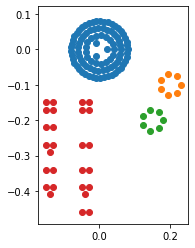

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for key in coord_area:
    
    if "coord" in key:
        ax.scatter(coord_area[key][:,0], coord_area[key][:,1])
        
ax.set_aspect('equal')

In [ ]:
# extract animal folder
anidatfolder, aniresfolder, animetafolder = animal_folder(animal = 'Pinky')

# load simulated coordinates of areas
coord_area = simcoordLoad(animetafolder)

# set the area and coordinates of all electrodes
elec_area, elec_coord = setAreaPosofElec(coord_area)

# save folder for FC visualization
savefolder_fcvisual = os.path.join(aniresfolder, 'FCVisual')

# load texts_area
texts_area = plottexts(fontsize_area = 20)

### Beta band FC Visualization

In [37]:
# load beta1/beta2 ciCOH in normal and mild conditions
ciCOH_beta1_normal, ciCOH_beta1_mild, ciCOH_beta2_normal, ciCOH_beta2_mild = ciCOHBetabandLoad(aniresfolder)

In [36]:
import pandas as pd
df = pd.read_csv(os.path.join(animetafolder, 'pinky_locations.csv'), header = None)

areachns = dict()

for i, key in enumerate(df[0]):
    areachns[key] = df[1][i]


print(areachns)

{'lSMA': '117, 122, 127, 128', 'rSMA': '101, 102, 107, 112', 'lMC': '118, 123', 'lVA': '124, 130, 131', 'rVA': '103, 104', 'lVLo': '119, 120', 'rVLo': '110, 115', 'lVPLo': '121, 126, 132', 'rVPLo': '106, 111, 116', 'rCd1': '108, 113'}


In [38]:
print(ciCOH_beta1_normal.shape)

(142, 142, 374)


In [ ]:
# beta1 normal
bandciCOHVisulaSave(ciCOH_beta1_normal, 
                    bandname = "beta1", condition = "normal", 
                    savefolder = savefolder_fcvisual, 
                    elec_area = elec_area, elec_coord = elec_coord, 
                    texts_area = texts_area)

# beta1 mild
bandciCOHVisulaSave(ciCOH_beta1_mild, 
                    bandname = "beta1", condition = "mild", 
                    savefolder = savefolder_fcvisual, 
                    elec_area = elec_area, elec_coord = elec_coord, 
                    texts_area = texts_area)

In [ ]:
# beta2 normal
bandciCOHVisulaSave(ciCOH_beta2_normal, 
                    bandname = "beta2", condition = "normal", 
                    savefolder = savefolder_fcvisual, 
                    elec_area = elec_area, elec_coord = elec_coord, 
                    texts_area = texts_area)

# beta2 mild
bandciCOHVisulaSave(ciCOH_beta2_mild, 
                    bandname = "beta2", condition = "mild", 
                    savefolder = savefolder_fcvisual, 
                    elec_area = elec_area, elec_coord = elec_coord, 
                    texts_area = texts_area)

### Alpha band FC Visualization

In [ ]:
# load beta1/beta2 ciCOH in normal and mild conditions
ciCOH_alpha_normal,  ciCOH_alpha_mild = ciCOHAlphabandLoad(aniresfolder)

In [ ]:
# alpha normal
bandciCOHVisulaSave(ciCOH_alpha_normal, 
                    bandname = "alpha", condition = "normal", 
                    savefolder = savefolder_fcvisual, 
                    elec_area = elec_area, elec_coord = elec_coord, 
                    texts_area = texts_area)

# beta2 mild
bandciCOHVisulaSave(ciCOH_alpha_mild, 
                    bandname = "alpha", condition = "mild", 
                    savefolder = savefolder_fcvisual, 
                    elec_area = elec_area, elec_coord = elec_coord, 
                    texts_area = texts_area)